In [42]:
import numpy as np
import cv2
from cv2 import Mat
import random
from IPython.display import Image, display

In [43]:
class TransferedPicture: #画像の相似変換
    def __init__(self,pic:Mat,scale,theta):
        self.orig_img=cv2.cvtColor(pic,cv2.COLOR_BGR2GRAY)
        h,w=self.orig_img.shape
        mat = cv2.getRotationMatrix2D((w / 2, h / 2), theta, scale) #相似変換のパラメータ設定
        self.img = cv2.warpAffine(self.orig_img, mat, (w, h)) #相似変換を実行
        self.scale=scale
        self.theta=theta
    
    def write(self,img_name):
        cv2.imwrite(img_name,self.img)
        
    def get_img_array(self): #オリジナル画像と変換後画像の配列を得る
        return self.orig_img, self.img

    def get_deff_array(self,img,axis=0): #微分画像を得る
        #axis=0: x方向の微分, axis=1: y方向の微分
        h,w=img.shape
        mat=np.zeros([h,w])
        for i in range(1,h-1):
            for j in range(1,w-1):
                if axis==0:
                    #if img[i][j+1]-img[i][j-1]<0:
                    #    print("hoge")
                    mat[i][j]=(int(img[i][j+1])-int(img[i][j-1]))*0.5
                elif axis==1:
                    mat[i][j]=(int(img[i+1][j])-int(img[i-1][j]))*0.5
        return mat

    def smooth_def(self): #x方向,y方向それぞれの平滑微分画像を生成
        self.gs=cv2.GaussianBlur(self.img,(3,3),3)
        #x方向の平滑微分画像
        dst_x=self.get_deff_array(self.gs,axis=0)
        #y方向の微分
        dst_y=self.get_deff_array(self.gs,axis=1)
        
        return dst_x,dst_y

In [44]:
class GaussNewton:
    def __init__(self,orig:np.array,st:np.array,i_x:np.array,i_y:np.array,theta:float,scale:float):
        #θとsを初期化
        self.theta=theta*np.pi/180
        self.scale=scale
        #各画像配列を保持
        self.orig=orig
        self.st=st
        self.i_x,self.i_y=i_x,i_y
        self.h,self.w=orig.shape
    
    #各微分値
    def dx_dtheta(self,x,y):
        return self.scale*(-2*x*np.sin(self.theta)-(2*y*np.cos(self.theta)))
    def dy_dtheta(self,x,y):
        return self.scale*(2*x*np.cos(self.theta)-(2*y*np.sin(self.theta)))
    def dx_dscale(self,x,y):
        return 2*x*np.cos(self.theta)-(2*y*np.sin(self.theta))
    def dy_dscale(self,x,y):
        return 2*x*np.sin(self.theta)+(2*y*np.cos(self.theta))
    
    #1周分の計算を行う
    def calc_param(self):
        h,w=int(self.h/2),int(self.w/2)
        j_t=j_tt=j_s=j_ss=j_ts=.0
        #print("θ={0}, s={1}".format(self.theta*180/np.pi,self.scale))
        for i in range(-1*h,h):
            for j in range(-1*w,w):
                #配列の座標を画像の中心を原点とした座標に変換
                x,y=j,-1*i #y軸の正の方向を向かせる
                #x,y=i,-1*j
                x_d=int(self.scale*(np.cos(self.theta)*x-(np.sin(self.theta)*y)))
                y_d=int(self.scale*(np.sin(self.theta)*x+(np.cos(self.theta)*y)))
                
                #各微分値
                dxdt=self.dx_dtheta(x_d,y_d)
                dydt=self.dy_dtheta(x_d,y_d)
                dxds=self.dx_dscale(x_d,y_d)
                dyds=self.dy_dscale(x_d,y_d)
                
                #配列の座標値に逆変換
                x,y=x+w,-1*y+h
                x_d,y_d=x_d+w-1,-1*y_d+h-1
                if x_d>self.w:
                    print("error",y_d,x_d)
                    
                I_dash=float(self.st[y_d][x_d])
                I=float(self.orig[y][x])
                I_dash_x=float(self.i_x[y_d][x_d])
                I_dash_y=float(self.i_y[y_d][x_d])

                j_t+=(I_dash-I)*(I_dash_x*dxdt+(I_dash_y*dydt))
                j_tt+=np.square(I_dash_x*dxdt+(I_dash_y*dydt))
                j_s+=(I_dash-I)*(I_dash_x*dxds+(I_dash_y*dyds))
                j_ss+=np.square(I_dash_x*dxds+(I_dash_y*dyds))
                j_ts+=(I_dash_x*dxdt+(I_dash_y*dydt))*(I_dash_x*dxds+(I_dash_y*dyds))
        
        #print("j_t={0} j_tt={1} j_s={2} j_ss={3} j_ts={4}".format(j_t,j_tt,j_s,j_ss,j_ts))
        #delta_thetaとdelta_scaleの計算
        mt=np.array([[j_tt,j_ts],[j_ts,j_ss]])
        deltas=-1*np.linalg.pinv(mt).dot(np.array([j_t,j_s]).T)
        #print("Δθ={0}, Δs={1}".format(deltas[0]*180/np.pi,deltas[1]))
        return deltas[0],deltas[1]
    
    def until_convergence(self):
        eps=0.00005
        old_dt=old_ds=1000
        i=1
        while(True):
            #print("{0}周目".format(i))
            new_dt,new_ds=self.calc_param()
            self.theta+=new_dt
            self.scale+=new_ds
            if abs(new_dt-old_dt)<eps and abs(new_ds-old_ds)<eps:
                print("収束を確認 {0}周目".format(i))
                print("最終値: θ={0}, s={1}".format(self.theta*180/np.pi,self.scale))
                break
            i+=1
            old_dt,old_ds=new_dt,new_ds

In [45]:
def imshow(img):
    #ndarray 配列から画像をNotebook上に表示
    ret, encoded = cv2.imencode(".jpg", img)
    display(Image(encoded))

In [46]:
orig_name="sc1.png"
pic_orig_name="pic2.png"
pic_st_name="pic3.png"

#thetaとscaleの初期値を適当に決める
s,t=0.5,100
tp=TransferedPicture(pic=cv2.imread(orig_name),scale=s,theta=t)
tp.write(pic_st_name)

#画像データを得る
orig_img,st_img=tp.get_img_array()
orig_array,st_array=np.array(orig_img),np.array(st_img)
cv2.imwrite(pic_orig_name,orig_img)

#Iの計算
i_x,i_y=tp.smooth_def()
i_x_array,i_y_array=np.array(i_x),np.array(i_y)

In [38]:
#ガウスニュートン法によるパラメータ推定
for i in range(1,11):
    theta=20*i
    scale=0.3
    gn=GaussNewton(orig=orig_array,st=st_array,i_x=i_x_array,i_y=i_y_array,theta=theta,scale=scale)
    gn.until_convergence()

収束を確認
213周目
最終値: θ=-21.968211504764096, s=0.231028570062134
収束を確認
165周目
最終値: θ=-21.967552542461, s=0.23105513950682963
収束を確認
86周目
最終値: θ=-21.966247132260314, s=0.23109220345072565
収束を確認
88周目
最終値: θ=99.74159251034135, s=0.4905779322960459
収束を確認
63周目
最終値: θ=99.77063423242122, s=0.49072783246708307


KeyboardInterrupt: 

θ=20, s=0.6


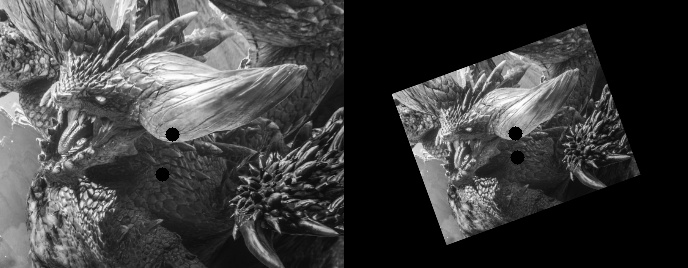

(162, 174, 173, 157)

In [9]:
scale,theta=s,t
h,w=orig_array.shape
#座標変換の計算が合っているかを確認

h,w=int(h/2),int(w/2)
j_t=j_tt=j_s=j_ss=j_ts=.0
print("θ={0}, s={1}".format(theta,scale))
j,i=-10,40
#配列の座標を画像の中心を原点とした座標に変換
x,y=j,-1*i #y軸の正の方向を向かせる
x_d=int(scale*(np.cos(np.radians(theta))*x-(np.sin(np.radians(theta))*y)))
y_d=int(scale*(np.sin(np.radians(theta))*x+(np.cos(np.radians(theta))*y)))
#配列の座標値に逆変換
x,y=x+w,-1*y+h
x_d,y_d=x_d+w-1,-1*y_d+h-1

pointed1=cv2.circle(orig_array,         # 図形入力画像
           (x,y),   # 開始点の座標(X,Y)
           7,          # 半径
           (0,0,255),   # カラーチャネル(B,G,R) 
           -1           # セルの太さ（-1にすると塗りつぶしになる）
          ) 
pointed2=cv2.circle(st_array,         # 図形入力画像
           (x_d,y_d),   # 開始点の座標(X,Y)
           7,          # 半径
           (0,0,255),   # カラーチャネル(B,G,R) 
           -1           # セルの太さ（-1にすると塗りつぶしになる）
          )   
imgs=cv2.hconcat([pointed1,pointed2])
imshow(imgs)

x,y,x_d,y_d

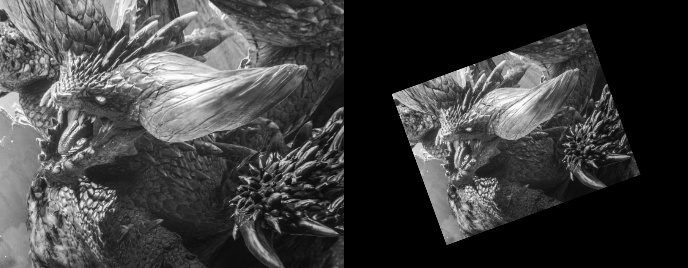

In [15]:
imgs=cv2.hconcat([orig_img,st_img])
imshow(imgs)

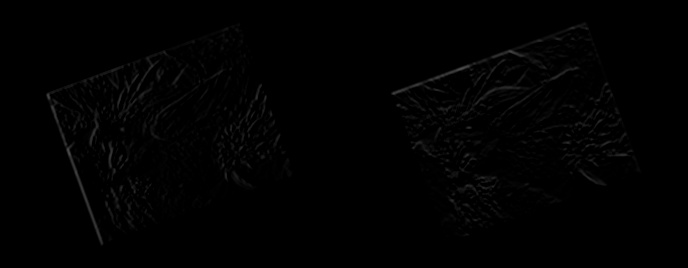

In [16]:
imgs=cv2.hconcat([i_x,i_y])
imshow(imgs)

In [35]:
h,w=orig_array.shape
h,w=int(h/2),int(w/2)
scale,theta=0.6,20

j,i=-94,94
x,y=j,-1*i #y軸の正の方向を向かせる
x_d=int(scale*(np.cos(np.radians(theta))*x-(np.sin(np.radians(theta))*y)))
y_d=int(scale*(np.sin(np.radians(theta))*x+(np.cos(np.radians(theta))*y)))
x,y=x+w,-1*y+h
x_d,y_d=x_d+w-1,-1*y_d+h-1
I_dash=st_array[x_d][y_d]
I=orig_array[x][y]
I_dash_x=i_x_array[x_d][y_d]
I_dash_y=i_y_array[x_d][y_d]
#orig_array[x][y],st_array[x_d][y_d],orig_array[y][x],st_array[y_d][x_d]
I_dash,I,I_dash_x,I_dash_y

(120, 121, 126.5, 125.5)

In [21]:
20*np.pi/180

0.3490658503988659